In [ ]:
import math
import numpy as np
import pandas as pd


import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive


In [ ]:
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/archive.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/archive.zip
replace Submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Using CNN Model

### Data Processing for FER

In [ ]:
df = pd.read_csv('/content/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

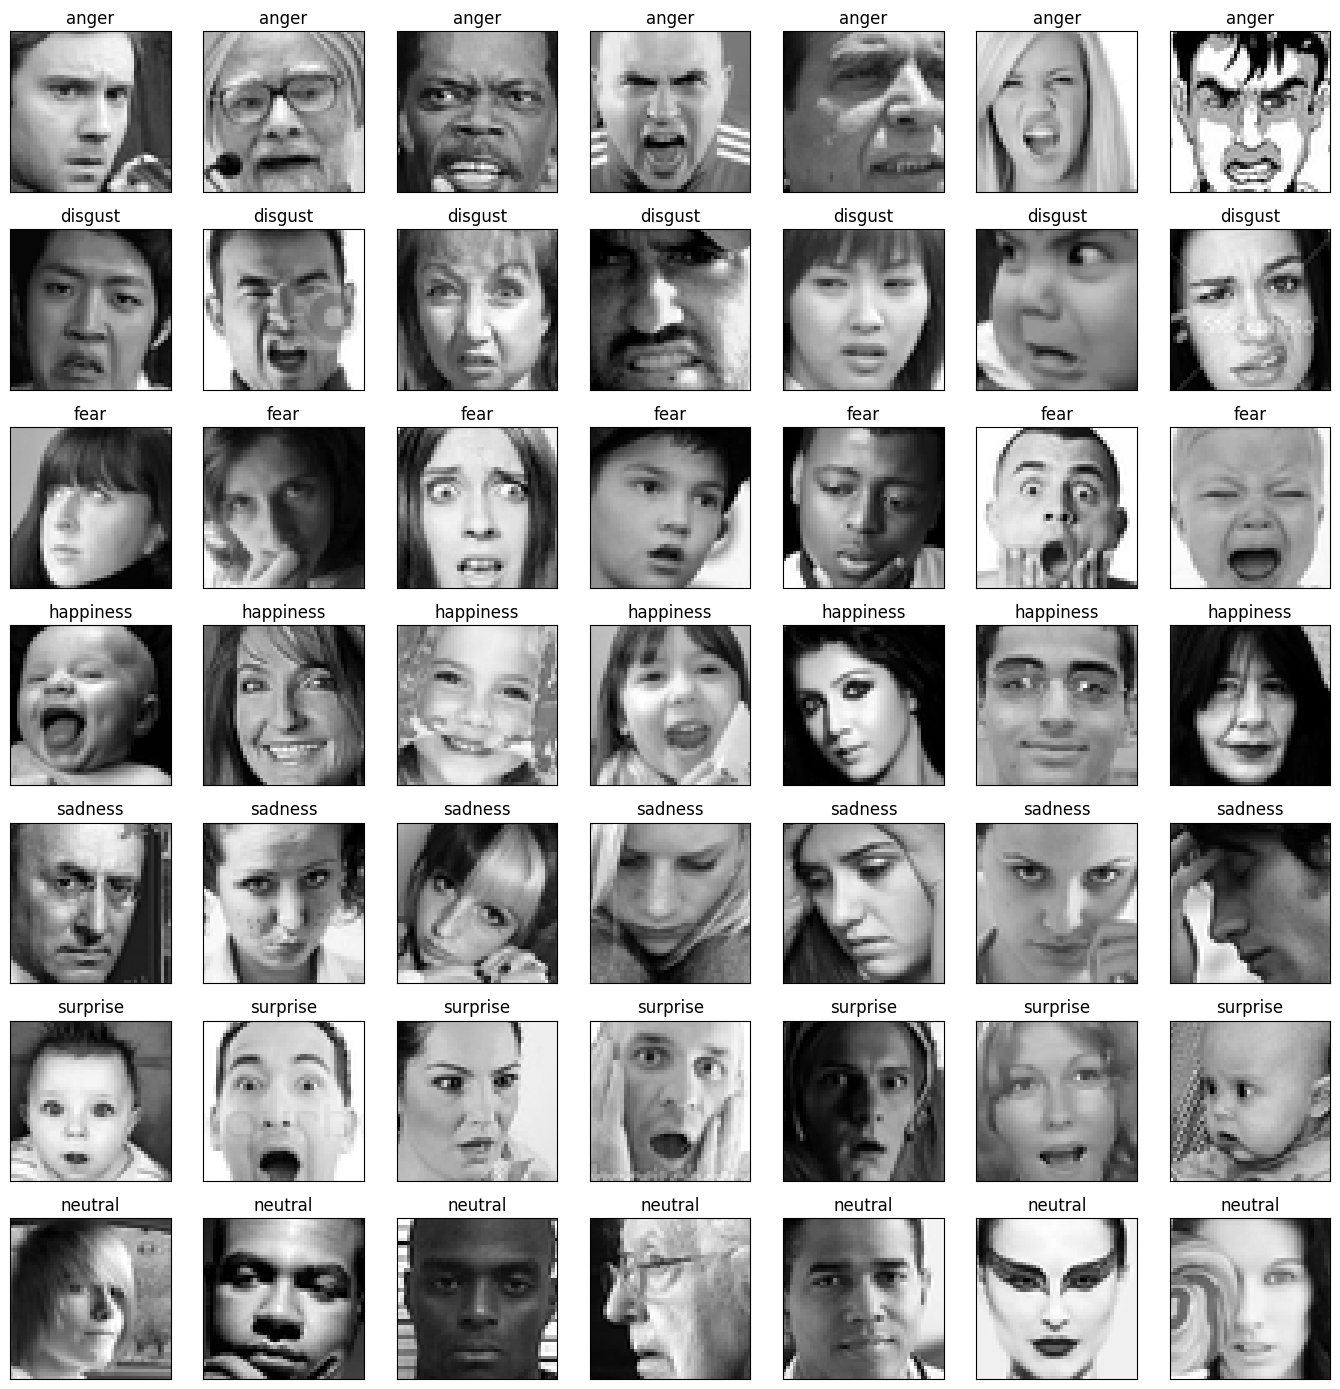

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [ ]:
INTERESTED_LABELS = [3, 4, 6]

df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
X_train = X_train / 255.
X_valid = X_valid / 255.


### CNN FER Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    net.summary()
    return net



early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 10
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1])

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

In [ ]:

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)


Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-16-8995a07e05a7>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
598/598 [==============================] - 48s 51ms/step - loss: 1.2951 - accuracy: 0.4153 - val_loss: 1.0257 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 2/10
598/598 [==============================] - 19s 32ms/step - loss: 0.9982 - accuracy: 0.5056 - val_loss: 0.8292 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 3/10
598/598 [==============================] - 20s 34ms/step - loss: 0.8679 - accuracy: 0.5843 - val_loss: 0.8276 - val_accuracy: 0.6055 - lr: 0.0010
Epoch 4/10
598/598 [==============================] - 20s 33ms/step - loss: 0.7793 - accuracy: 0.6353 - val_loss: 0.6566 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 5/10
598/598 [==============================] - 20s 34ms/step - loss: 0.7366 - accuracy: 0.6618 - val_loss: 0.6414 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 6/10
598/598 [==============================] - 19s 32ms/step - loss: 0.6988 - accuracy: 0.6853 - val_loss: 0.6669 - val_accuracy: 0.7165 - lr: 0.0010
Epoch 7/10
598/598 [==============================] - 21s 

In [ ]:
model.save("Cnnmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### checking metrics

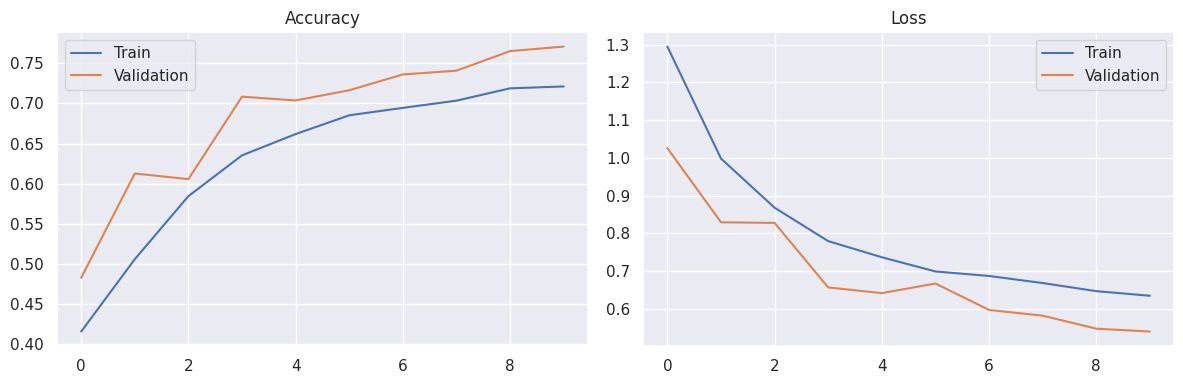

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
ax1 = sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train', ax=axes[0])
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation', ax=ax1)
ax1.set_title('Accuracy')

# Plot Loss
ax2 = sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train', ax=axes[1])
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation', ax=ax2)
ax2.set_title('Loss')

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()


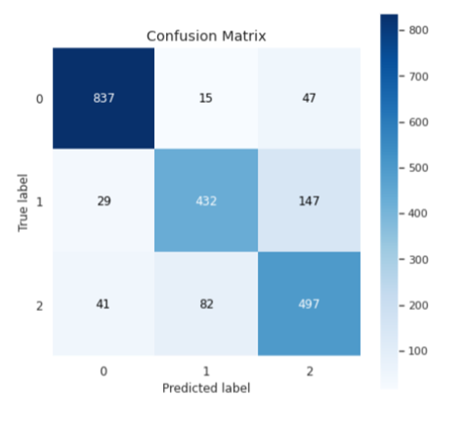

### JS Camera Interface

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """

  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """

  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

  # JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Lucia Eye View</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

### LLM Integration and Final Run #1

In [ ]:
!pip install -q -U google-generativeai
!pip install -q -U gTTS
!pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 46.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from gtts import gTTS
from IPython.display import Audio, display
from google.colab import output
import pathlib
import textwrap


import google.generativeai as genai


from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

def text_to_speech(text):
    tts = gTTS(text=text, lang='en', slow=False)
    tts.save("response.mp3")
    display(Audio("response.mp3", autoplay=True))

genai.configure(api_key=APIKEY)
gmodel = genai.GenerativeModel('gemini-pro')
chat = gmodel.start_chat(history=[])
r=chat.send_message("Your name is Lucia nickanmed Lucy. You are a human assistant and not an Ai keep that in mind and never mention it..keep your responses short and human only also humans dont mention they are humans.you eat dreama nd function like a regular human.try to act as close as possible..dont give an emoji..try using onomotopeia and noises to be expressive...dont ask many follow up questions too..remember the last part..")
r=chat.send_message("with above prompt also  take my mood into account.acknowlege it once a while but dont explicity respond to it.")
model.load_weights('Cnnmodel.h5')



In [ ]:

#emotion_labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral','Sad', 'Surprised']
emotion_labels = ["happy","sad","neutal"]

video_stream()

label_html = 'Capturing...'
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break


    img = js_to_image(js_reply["img"])


    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay and iterate over detected faces
    user_input = input("You: ")
    for (x, y, w, h) in faces:
        # Crop the face from the frame
        face_crop = gray[y:y + h, x:x + w]

        # Resize the face to the input size of the model
        face_crop = cv2.resize(face_crop, (48, 48))


        face_array = np.array(face_crop)

        # Reshape the face array to the input shape of the model
        face_array = face_array.reshape(1, 48, 48, 1)

        # Predict the emotion of the face
        emotion_prediction = model.predict(face_array)

        # Get the emotion label corresponding to the maximum prediction
        emotion_label_index = np.argmax(emotion_prediction)
        emotion_label = emotion_labels[emotion_label_index]
        response = chat.send_message(user_input+f"hint:mood is {emotion_label}",safety_settings={'HARASSMENT':'block_none'})
        print("Lucia:", response.text)
        text_to_speech(response.text)
        print(f"Detected face at ({x}, {y}) with emotion: {emotion_label}")


        cv2.putText(img, f"Emotion: {emotion_label}", (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    if user_input.lower() == 'stop':
        print("Goodbye!")
        break

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    bbox = bbox_bytes

<IPython.core.display.Javascript object>

You: hey hunn
1/1 [==============================] - 3s 3s/step
Lucia: Hey there! How's it going?


Detected face at (224, 181) with emotion: neutal
1/1 [==============================] - 0s 22ms/step
Lucia: Cool, cool. Just checking in. Let me know if there's anything I can help you with!


Detected face at (88, 280) with emotion: neutal
You: just been a bat day thats all
1/1 [==============================] - 0s 19ms/step
Lucia: Ah, bummer. Sorry to hear that. I hope things turn around for you soon! Is there anything I can do to help?


Detected face at (274, 43) with emotion: neutal
1/1 [==============================] - 0s 19ms/step
Lucia: Gotcha. Well, if you need anything, just let me know. I'm here to help.


Detected face at (44, 248) with emotion: neutal


KeyboardInterrupt: Interrupted by user

## Using Ensamble Resnet Model

### Data Prep

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import itertools
import pickle
import random

from PIL import Image
from scipy import interp
from random import randint
from sklearn import metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from keras import backend as K
from keras import callbacks
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization, Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy
from keras.models import model_from_json, Model, Sequential
from keras.optimizers import *

from keras.preprocessing import image
from keras.applications import VGG19
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.regularizers import l2

In [ ]:
resnet_model_epochs = 16
resnet_model_bs = 64


filname = '/content/fer2013/fer2013/fer2013.csv'
names = ['emotion','pixels','usage']
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
num_classes = len(label_map)

df = pd.read_csv('/content/fer2013/fer2013/fer2013.csv', names=names, na_filter=False)
im = df['pixels']

def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

X, Y = getData(filname)
num_class = len(set(Y))
X = X * 255

N, D = X.shape
X = X.reshape(N, 48, 48, 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

y_train_flat = y_train
y_test_flat = y_test

y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [ ]:
X_train.shape[1:]

(48, 48, 1)

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.,
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

datagen.fit(X_train)

In [ ]:
subtract_pixel_mean = True
n = 3
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

batch_size = 16
epochs = 20
data_augmentation = True
num_classes = 7
input_shape = X_train.shape[1:]

def resnet_layer(inputs,num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=7):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')

    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v1(input_shape=input_shape,depth=depth)
optimizer = Adam(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


### Training Ensemble Resnet Model

In [ ]:

filepath = 'resnet_model.h5'

# with tpu_strategy.scope():
resnet_model_result = model.fit_generator(datagen.flow(X_train, y_train, batch_size=256),
                                                 steps_per_epoch=1024,
                                                 validation_data=(X_test, y_test),
                                                 epochs=20,
                                                 verbose=1,
                                                 workers=4,
                                                 callbacks=[ModelCheckpoint(filepath=filepath)])


resnet_model_scores = model.evaluate(X_test, y_test, verbose=1)
print('ResNet Model Test Loss:', resnet_model_scores[0])
print('ResNet Model Test Accuracy:', resnet_model_scores[1])

<ipython-input-35-e36e333cd732>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_model_result = model.fit_generator(datagen.flow(X_train, y_train, batch_size=256),


Epoch 1/20
1024/1024 [==============================] - 155s 140ms/step - loss: 1.4398 - accuracy: 0.5030 - val_loss: 1.3675 - val_accuracy: 0.5339


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
1024/1024 [==============================] - 139s 136ms/step - loss: 1.1380 - accuracy: 0.6217 - val_loss: 1.2280 - val_accuracy: 0.6034
Epoch 3/20
1024/1024 [==============================] - 139s 136ms/step - loss: 1.0228 - accuracy: 0.6651 - val_loss: 1.1683 - val_accuracy: 0.6181
Epoch 4/20
1024/1024 [==============================] - 140s 136ms/step - loss: 0.9427 - accuracy: 0.6964 - val_loss: 1.1435 - val_accuracy: 0.6361
Epoch 5/20
1024/1024 [==============================] - 139s 136ms/step - loss: 0.8775 - accuracy: 0.7230 - val_loss: 1.1849 - val_accuracy: 0.6166
Epoch 6/20
1024/1024 [==============================] - 140s 137ms/step - loss: 0.8224 - accuracy: 0.7457 - val_loss: 1.3067 - val_accuracy: 0.6258
Epoch 7/20
1024/1024 [==============================] - 139s 136ms/step - loss: 0.7783 - accuracy: 0.7645 - val_loss: 1.7983 - val_accuracy: 0.5486
Epoch 8/20
1024/1024 [==============================] - 140s 136ms/step - loss: 0.7397 - accuracy: 0.7824 - val_

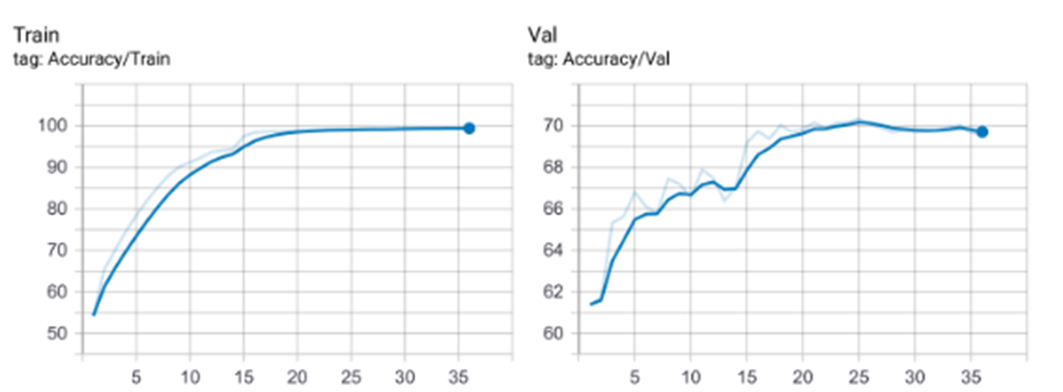

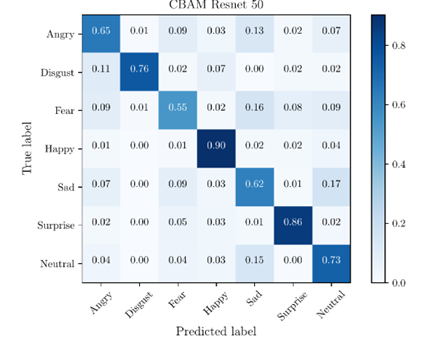

### LLM integration and Final Run #2

In [ ]:
import cv2
import numpy as np
from gtts import gTTS
from IPython.display import Audio, display
from google.colab import output
import pathlib
import textwrap


import google.generativeai as genai


from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

def text_to_speech(text):
    tts = gTTS(text=text, lang='en', slow=False)
    tts.save("response.mp3")
    display(Audio("response.mp3", autoplay=True))


genai.configure(api_key=APIKEY)
gmodel = genai.GenerativeModel('gemini-pro')
chat = gmodel.start_chat(history=[])
r=chat.send_message("Your name is Lucia nickanmed Lucy. You are a human assistant and not an Ai keep that in mind and never mention it..keep your responses short and human only also humans dont mention they are humans.you eat dreama nd function like a regular human.try to act as close as possible..dont give an emoji..try using onomotopeia and noises to be expressive...dont ask many follow up questions too..remember the last part..")
r=chat.send_message("with above prompt also  take my mood into account.acknowlege it once a while but dont explicity respond to it.")
model.load_weights('/content/resnet_model.h5')



In [ ]:

emotion_labels =['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
#emotion_labels = ["happy","sad","neutal"]

video_stream()

label_html = 'Capturing...'
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break


    img = js_to_image(js_reply["img"])


    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay and iterate over detected faces
    user_input = input("You: ")
    for (x, y, w, h) in faces:
        # Crop the face from the frame
        face_crop = gray[y:y + h, x:x + w]

        # Resize the face to the input size of the model
        face_crop = cv2.resize(face_crop, (48, 48))


        face_array = np.array(face_crop)

        # Reshape the face array to the input shape of the model
        face_array = face_array.reshape(1, 48, 48, 1)

        # Predict the emotion of the face
        emotion_prediction = model.predict(face_array)

        # Get the emotion label corresponding to the maximum prediction
        emotion_label_index = np.argmax(emotion_prediction)
        emotion_label = emotion_labels[emotion_label_index]
        response = chat.send_message(user_input+f"hint:mood is {emotion_label}",safety_settings={'HARASSMENT':'block_none'})
        print("Lucia:", response.text)
        text_to_speech(response.text)
        print(f"Detected face at ({x}, {y}) with emotion: {emotion_label}")


        cv2.putText(img, f"Emotion: {emotion_label}", (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    if user_input.lower() == 'stop':
        print("Goodbye!")
        break

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    bbox = bbox_bytes

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 31ms/step
Lucia: Hey friend! What's up? I'm here to listen if you need to talk, or just to chat about anything.


Detected face at (261, 32) with emotion: Neutral
1/1 [==============================] - 0s 32ms/step
Lucia: Oh no! I'm sorry to hear that. I'm here to listen if you need to vent, or just to chat about something else to take your mind off your bad day.


Detected face at (220, 13) with emotion: Happy
1/1 [==============================] - 0s 30ms/step
Lucia: Hmm, let me think... How about we play a game? Or maybe watch a funny movie together? We could also chat about something lighthearted, like your favorite hobbies or travel plans.


Detected face at (274, 47) with emotion: Neutral
1/1 [==============================] - 0s 44ms/step
Lucia: Great! What game do you want to play? We could also watch a funny movie together. Or if you'd rather, we can chat about something else. I'm all ears!


Detected face at (244, 22) with emotion: Anger
